In [1]:
# IMPORT PACKAGES/LIBRARIES
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.transforms import Normalize
import torch.nn.functional as F
import numpy as np
import csv
import os
import math
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# IMPORT THE DATA; 
# Feature Scaling

## Inputs:  
def preprocess_data():
    npy_filepath = "/home/ngsci/datasets/silent-cchs-ecg/npy"
    dir_list = os.listdir(npy_filepath)
    npy_arrays = []
    for each in dir_list:
        file = f"{npy_filepath}/{each}"
        npy_arrays.append(np.load(file).astype(np.float32))

    input_arrays = np.stack(npy_arrays, axis=0)
    input_arrays = torch.from_numpy(input_arrays)
    input_arrays = input_arrays.permute(1, 0, 2, 3)
    input_arrays = input_arrays.reshape(3750, 12, 5500)
    input_arrays = input_arrays.reshape(3750, 5500, 12)
    input_arrays = input_arrays[:, :5000, :]
    input_arrays = input_arrays.numpy()

    return input_arrays


def feature_scaling(input_arrays):
    scaler = Normalizer().set_output(transform="pandas")
    for x in range(0, input_arrays.shape[0]):
        array = input_arrays[x]
        scaler.fit(array)
        array = scaler.transform(array).to_numpy()
        input_arrays[x] = array
    return input_arrays

stacked = preprocess_data()
stacked = feature_scaling(stacked)
stacked = torch.from_numpy(stacked)


#Outputs:
rwma = pd.read_csv("/home/ngsci/datasets/silent-cchs-ecg/csv/rwma-outcomes.csv")
rwma = rwma.astype(float)
rwma = torch.tensor(rwma.iloc[:,1], dtype=torch.long)

In [23]:
# CUSTOMIZED DATASET CLASS
#
#
class EcgData(Dataset):
    def __init__(self, x, y, trainsize):
        self.x_train, self.y_train, self.x_test, self.y_test, self.x_val, self.y_val = self.split_data(x, y, trainsize)

    def split_data(self, x, y, trainsize):
        # split into trainsize x rest/2 x rest/2
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 - trainsize, shuffle=False)
        x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)  # split test data (20%) into 50% chunks

        return x_train, y_train, x_test, y_test, x_val, y_val

    def __getitem__(self, index):
        if index < len(self.x_train):
            x, y = self.x_train[index], self.y_train[index]
        elif index < len(self.x_train) + len(self.x_test):
            offset = len(self.x_train)
            x, y = self.x_test[index - offset], self.y_test[index - offset]
        else:
            offset = len(self.x_train) + len(self.x_test)
            index -= offset
            index %= len(self.x_val)
            x, y = self.x_val[index], self.y_val[index]

        return x, torch.unsqueeze(y, dim=0)

    def __len__(self):
        return len(self.x_train) + len(self.x_test) + len(self.x_val)


In [24]:
## Splitting the DATA
##
x = stacked #features
y = rwma    # labels
trainsize = 0.8 

#Split the data
train_dataset = EcgData(x, y, trainsize)
test_dataset = EcgData(x, y, trainsize)
val_dataset = EcgData(x, y, trainsize)

x_train, y_train, x_test, y_test, x_val, y_val = train_dataset.x_train, train_dataset.y_train, test_dataset.x_test, test_dataset.y_test, val_dataset.x_val, val_dataset.y_val

##FF transorm
x_train = torch.abs(torch.fft.fft(x_train, dim=2))
x_test = torch.abs(torch.fft.fft(x_test, dim=2))
x_val = torch.abs(torch.fft.fft(x_val, dim=2))


In [25]:
## DATALOADER with sampler
def create_resampler(labels):
    unique, counts = np.unique(labels[:], return_counts=True)
    class_counts = [counts[0], counts[1]]
    num_samples = max(class_counts)

    resampled_labels = []
    for i, count in enumerate(class_counts):
        resampled_labels.extend(
            np.random.choice(np.where(labels == i)[0], size=num_samples, replace=True)
        )

    resampled_weights = np.ones(len(resampled_labels))
    resampler = torch.utils.data.WeightedRandomSampler(
        torch.DoubleTensor(resampled_weights), len(resampled_labels), replacement=True
    )

    return resampler


def create_dataloader(trainset, testset, valset, batch_size, y_train, y_test, y_val):
    train_resampler = create_resampler(y_train)
    test_resampler = create_resampler(y_test)
    val_resampler = create_resampler(y_val)

    train_loader = DataLoader(
        dataset=trainset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=3,
        sampler=train_resampler,
    )
    test_loader = DataLoader(
        dataset=testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=3,
        sampler=test_resampler,
    )
    val_loader = DataLoader(
        dataset=valset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=3,
        sampler=val_resampler,
    )

    sets = [trainset, testset, valset]
    for i in sets:
        total_samples = len(i)
        n_iterations = math.ceil(total_samples / batch_size)

    return train_loader, test_loader, val_loader



## Create the DataLoaders:
train_loader, test_loader, val_loader = create_dataloader(train_dataset, test_dataset, val_dataset, 64, y_train, y_test, y_val)

In [65]:
class ECG_RNN(nn.Module):
    """
    ECG_RNN is a neural network model designed for ECG data classification.
    It consists of an LSTM layer followed by fully connected layers.

    Args:
        num_channels (int): Number of input channels.
        sequence_length (int): Length of the input sequence.
        hidden_size (int): Size of the LSTM hidden state.
        num_layers (int): Number of LSTM layers.
        num_classes (int): Number of output classes.
        dropout (float): Dropout rate to apply.

    Attributes:
        hidden_size (int): Size of the LSTM hidden state.
        num_layers (int): Number of LSTM layers.
        rnn (nn.LSTM): LSTM layer for sequence processing.
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.
        dropout (nn.Dropout): Dropout layer for regularization.

    Methods:
        forward(x): Forward pass of the model.

    """

    def __init__(self, num_channels=12, sequence_length=5000, hidden_size=64, num_layers=2, num_classes=1, dropout=0.4):
        super(ECG_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(sequence_length, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_size*2, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Forward pass of the ECG_RNN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, num_channels).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).

        """
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, sequence_length, num_channels)
        _, (h_n, _) = self.rnn(x)
        x = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)  # Concatenate hidden states from both directions
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [66]:
class_counts = [0, 0]  # Initialize counts for each class

for batch_idx, (features, labels) in enumerate(train_loader):
    # Count the number of samples in each class
    class_counts[0] += torch.sum(labels == 0).item()
    class_counts[1] += torch.sum(labels == 1).item()

total_samples = sum(class_counts)  # Total number of samples

class_distribution = [count / total_samples for count in class_counts]
print(class_distribution)

[0.901651376146789, 0.09834862385321101]


In [67]:
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

def generate_heatmap(model, data_loader, device):
    model.eval()
    confusion = torch.zeros(2, 2, device=device)  # Initialize confusion matrix on the same device

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            predicted = torch.round(torch.sigmoid(outputs))

            # Update confusion matrix
            for i in range(len(predicted)):
                confusion[predicted[i].long(), labels[i].long()] += 1

    confusion = confusion.cpu().numpy()
    heatmap = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [68]:
## TRAIN Loop + l2 Regularization + metrics
def train(net, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    train_loss, val_loss = ([] for _ in range(2))
    auroc_scores = []
    train_loss_plot, val_loss_plot, auroc_plot = ([] for _ in range(3))

    print('\n\nTRAINING STARTED\n')

    for epoch in range(num_epochs):
        # TRAIN LOOP
        net.train()
        running_loss = []

        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            predicts = net(features)
            loss = criterion(predicts, labels.reshape(-1, 1).float())

            # Class weights for unbalanced data
            class_weights = torch.tensor(class_distribution).to(device)  # Move to the device
            loss = torch.mean(loss * class_weights[labels.long()])

            # Regularization
            l2_lambda = 0.001  # Regularization parameter
            l2_reg = torch.tensor(0.).to(device)
            for param in net.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training loss
            running_loss.append(loss.item())

        # Calculate average training loss
        train_loss.append(np.mean(running_loss))
        train_loss_plot.append(np.mean(running_loss))  # Store for plotting

        # Calculate validation loss
        net.eval()
        val_running_loss = []

        with torch.no_grad():
            for batch_idx, (features, labels) in enumerate(val_loader):
                features, labels = features.to(device), labels.to(device)

                # Forward pass
                predicts = net(features)
                loss = criterion(predicts, labels.reshape(-1, 1).float())

                # Calculate validation loss
                val_running_loss.append(loss.item())

        val_loss.append(np.mean(val_running_loss))
        val_loss_plot.append(np.mean(val_running_loss))  # Store for plotting

        # Calculate AUROC
        net.eval()
        y_true = []
        y_scores = []

        with torch.no_grad():
            for batch_idx, (features, labels) in enumerate(val_loader):
                features, labels = features.to(device), labels.to(device)

                # Forward pass
                predicts = net(features)

                # Collect true labels and predicted scores for AUROC calculation
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(predicts.cpu().numpy().flatten())

        auroc = roc_auc_score(y_true, y_scores)
        auroc_scores.append(auroc)
        auroc_plot.append(auroc)  # Store for plotting
        print(f'Epoch {epoch + 1}: Train Loss = {train_loss[epoch]:.3f}, Val Loss = {val_loss[epoch]:.3f}, AUROC = {auroc:.3f}')

        #Calc. accuracy
        train_accuracy = calculate_accuracy(net, train_loader, device)
        val_accuracy = calculate_accuracy(net, val_loader, device)
        print(f'Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}')
    
    print('\nTRAINING FINISHED\n\n')

    # Plot AUROC
    plt.plot(range(1, num_epochs + 1), auroc_plot)
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.title('AUROC over Epochs')
    plt.show()

    # Plot training and validation losses
    plt.plot(range(1, num_epochs + 1), train_loss_plot, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_plot, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
    # Calculate mean of losses
    loss_mean = np.mean(train_loss)
    val_loss_mean = np.mean(val_loss)

    return loss_mean, val_loss_mean




TRAINING STARTED

Epoch 1: Train Loss = 0.419, Val Loss = 0.264, AUROC = 0.657
Train Accuracy: 0.921, Val Accuracy: 0.909
Epoch 2: Train Loss = 0.252, Val Loss = 0.301, AUROC = 0.729
Train Accuracy: 0.944, Val Accuracy: 0.929
Epoch 3: Train Loss = 0.222, Val Loss = 0.223, AUROC = 0.785
Train Accuracy: 0.948, Val Accuracy: 0.920
Epoch 4: Train Loss = 0.198, Val Loss = 0.244, AUROC = 0.869
Train Accuracy: 0.945, Val Accuracy: 0.926
Epoch 5: Train Loss = 0.189, Val Loss = 0.194, AUROC = 0.842
Train Accuracy: 0.950, Val Accuracy: 0.929
Epoch 6: Train Loss = 0.170, Val Loss = 0.202, AUROC = 0.874
Train Accuracy: 0.962, Val Accuracy: 0.938
Epoch 7: Train Loss = 0.156, Val Loss = 0.166, AUROC = 0.893
Train Accuracy: 0.961, Val Accuracy: 0.948
Epoch 8: Train Loss = 0.147, Val Loss = 0.183, AUROC = 0.925
Train Accuracy: 0.959, Val Accuracy: 0.945
Epoch 9: Train Loss = 0.141, Val Loss = 0.152, AUROC = 0.910
Train Accuracy: 0.969, Val Accuracy: 0.947
Epoch 10: Train Loss = 0.131, Val Loss = 0.1

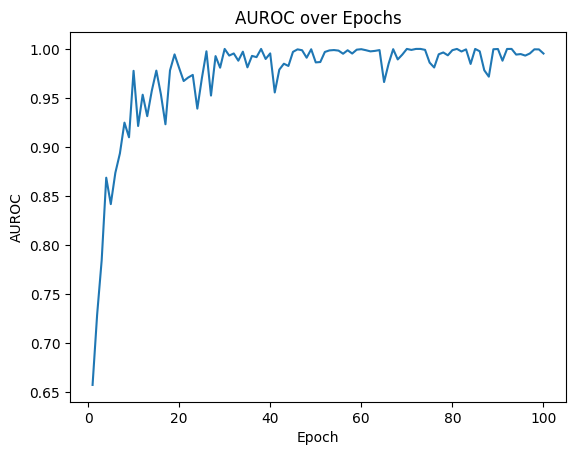

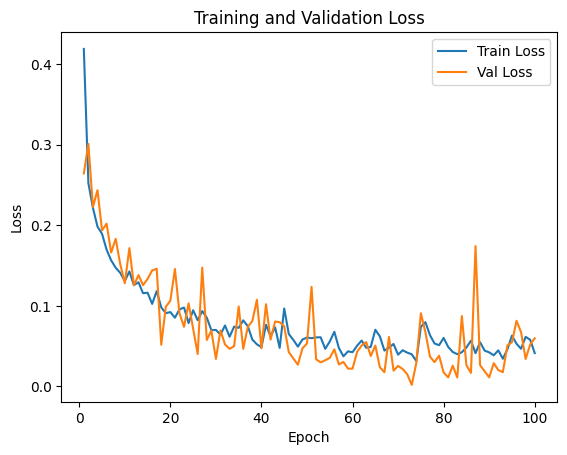

Test Loss: 0.045
AUROC: 0.999
Test Loss: 0.045
AUROC: 0.999
Train Accuracy: 0.990, Val Accuracy: 0.984


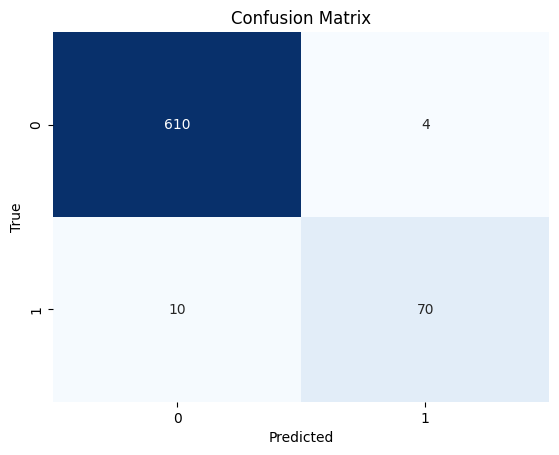

In [69]:
######################### MAIN #####################################
# Create an instance of ECG_RNN
# Adjust the hyperparameters as needed
num_channels = 12
sequence_length = 5000
hidden_size = 64
num_layers = 2
num_classes = 1
dropout = 0.4
num_epochs= 100
# Create an instance of the model
model = ECG_RNN(num_channels, sequence_length, hidden_size, num_layers, num_classes, dropout)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Train the model
train_loss, val_loss = train(model, criterion, optimizer, train_loader, val_loader, num_epochs, device=device)

# Test the model
test_loss, auroc = test(model, criterion, test_loader, device=device)
print(f'Test Loss: {test_loss:.3f}')
print(f'AUROC: {auroc:.3f}')

# Calculate accuracy
train_accuracy = calculate_accuracy(model, train_loader, device=device)
val_accuracy = calculate_accuracy(model, val_loader, device=device)
print(f'Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}')

# Generate heatmap
generate_heatmap(model, test_loader, device=device)
